In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import keras

import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.10,
                                  
                rotation_range=5,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                #zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=5,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest',
                                  validation_split = 0.1)

test_datagen  = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
        #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  )

In [5]:
#train_dir = f"{os.getcwd()}\\Alzheimer_s Dataset\\train"
test_dir = f"{os.getcwd()}\\Alzheimer_s Dataset\\test"
#test_dir = f"{os.getcwd()}\\generated_image"
train_dir = f"{os.getcwd()}\\Alzheimer_s Dataset_with_gen\\train"

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 8)

Found 8210 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 8)

Found 911 images belonging to 4 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 8)

Found 1279 images belonging to 4 classes.


In [10]:
base_model = tf.keras.applications.VGG19(input_shape=(224,224,3), 
                   include_top=False)
                   #weights="imagenet")


80134624/80134624 [==============================] - 4s 0us/step


In [11]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.01))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [231]:
# Freezing Layers
#for layer in base_model.layers:
    #layer.trainable=False

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [13]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score
] 

In [15]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [16]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)

In [17]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30 ,
                        verbose = 1)

Epoch 1/30
1027/1027 [==============================] - 149s 140ms/step - loss: 1.3346 - accuracy: 0.7330 - precision: 0.4043 - recall: 0.1432 - auc: 0.6528 - f1_score: 0.2030 - val_loss: 1.3682 - val_accuracy: 0.7250 - val_precision: 0.4431 - val_recall: 0.3886 - val_auc: 0.6807 - val_f1_score: 0.4133
Epoch 2/30
1027/1027 [==============================] - 142s 139ms/step - loss: 1.1544 - accuracy: 0.7543 - precision: 0.5233 - recall: 0.1927 - auc: 0.7385 - f1_score: 0.2703 - val_loss: 1.0157 - val_accuracy: 0.7744 - val_precision: 0.6878 - val_recall: 0.1789 - val_auc: 0.7919 - val_f1_score: 0.2654
Epoch 3/30
1027/1027 [==============================] - 143s 139ms/step - loss: 1.1573 - accuracy: 0.7518 - precision: 0.5102 - recall: 0.1789 - auc: 0.7347 - f1_score: 0.2545 - val_loss: 1.1849 - val_accuracy: 0.7505 - val_precision: 0.5556 - val_recall: 0.0110 - val_auc: 0.7167 - val_f1_score: 0.0191
Epoch 4/30
1027/1027 [==============================] - 143s 140ms/step - loss: 1.0951 -

Epoch 28/30
1027/1027 [==============================] - 142s 138ms/step - loss: 1.1568 - accuracy: 0.7691 - precision: 0.6264 - recall: 0.1895 - auc: 0.7376 - f1_score: 0.2848 - val_loss: nan - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: nan
Epoch 29/30
1027/1027 [==============================] - 142s 138ms/step - loss: 1.1492 - accuracy: 0.7689 - precision: 0.6274 - recall: 0.1862 - auc: 0.7395 - f1_score: 0.2813 - val_loss: nan - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: nan
Epoch 30/30
1027/1027 [==============================] - 143s 139ms/step - loss: 1.1291 - accuracy: 0.7743 - precision: 0.6590 - recall: 0.2012 - auc: 0.7463 - f1_score: 0.3020 - val_loss: nan - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: nan


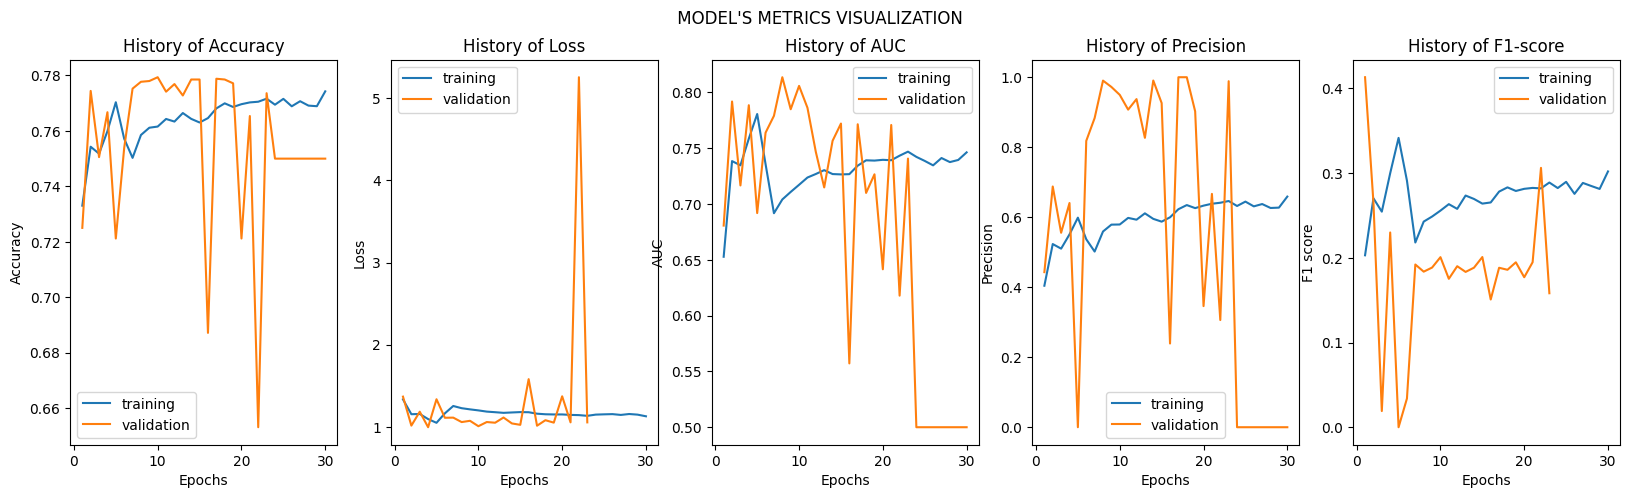

In [19]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [20]:
scores = model.evaluate_generator(test_dataset)

C:\Users\Guest-ccc\AppData\Local\Temp\ipykernel_11040\39297891.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataset)


In [21]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.75
Precision =  0.0
Recall =  0.0
AUC =  0.5
F1_score =  nan
